In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import numpy as np
from scipy.signal import convolve2d
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/stefan/kseta-topical-understanding-ml/py3_venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stefan/kseta-topical-understanding-ml/py3_venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stefan/kseta-topical-understanding-ml/py3_venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np

In [2]:
model = VGG16()
model.summary()

W0821 15:30:36.706048 140383864518400 deprecation_wrapper.py:119] From /home/stefan/kseta-topical-understanding-ml/py3_venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 15:30:36.765064 140383864518400 deprecation_wrapper.py:119] From /home/stefan/kseta-topical-understanding-ml/py3_venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 15:30:36.772737 140383864518400 deprecation_wrapper.py:119] From /home/stefan/kseta-topical-understanding-ml/py3_venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 15:30:36.918256 140383864518400 deprecation_wrapper.py:119] From /home/stefan/kseta-topical-understanding-ml/py3_venv/lib/python3.7/site-packages/keras/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Rank: 1, Label: Persian_cat, Score: 0.451
Rank: 2, Label: Siamese_cat, Score: 0.314
Rank: 3, Label: lynx, Score: 0.069
Rank: 4, Label: tabby, Score: 0.041
Rank: 5, Label: computer_keyboard, Score: 0.015


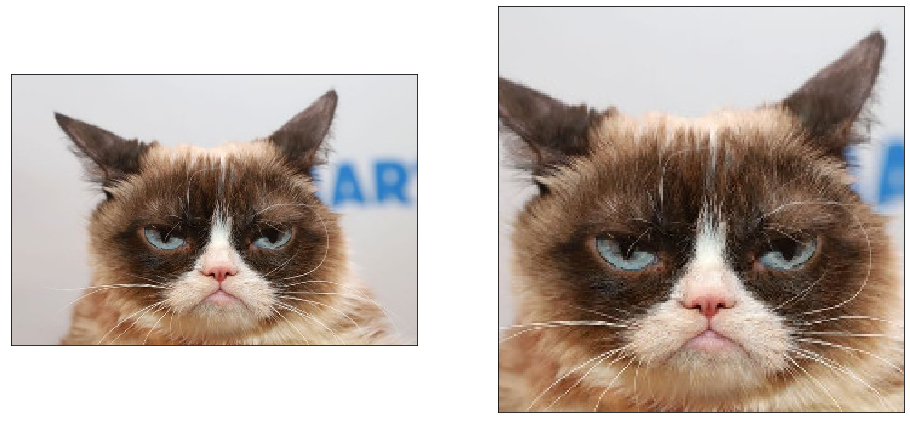

In [3]:
def center_crop(img, new_width=224, new_height=224):
    width = img.shape[1]
    height = img.shape[0]
    
    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))
    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))
    
    if any(np.array([left, right, top, bottom]) < 0):
        raise Exception("Cropped image has to be exactly of size 224x224. Your input image is too small.")

    return img[top:bottom, left:right]

img = load_img('cat.jpg')
imgarr = img_to_array(img)
imgarr = center_crop(imgarr)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(imgarr.astype(np.uint8))

imgarr_preproc = np.expand_dims(imgarr.copy(), axis=0)
imgarr_preproc = preprocess_input(imgarr_preproc)

pred = model.predict(imgarr_preproc)
labels = decode_predictions(pred, top=5)

for i, label in enumerate(labels[0]):
    print("Rank: {:}, Label: {:}, Score: {:.3f}".format(i + 1, label[1], label[2]))

In [4]:
for i, layer in enumerate(model.layers):
    if not 'conv' in layer.name:
        continue
    print("Index: {}, Name: {}, Shapes: {} -> {}".format(i, layer.name, layer.input.shape, layer.output.shape))

Index: 1, Name: block1_conv1, Shapes: (?, 224, 224, 3) -> (?, 224, 224, 64)
Index: 2, Name: block1_conv2, Shapes: (?, 224, 224, 64) -> (?, 224, 224, 64)
Index: 4, Name: block2_conv1, Shapes: (?, 112, 112, 64) -> (?, 112, 112, 128)
Index: 5, Name: block2_conv2, Shapes: (?, 112, 112, 128) -> (?, 112, 112, 128)
Index: 7, Name: block3_conv1, Shapes: (?, 56, 56, 128) -> (?, 56, 56, 256)
Index: 8, Name: block3_conv2, Shapes: (?, 56, 56, 256) -> (?, 56, 56, 256)
Index: 9, Name: block3_conv3, Shapes: (?, 56, 56, 256) -> (?, 56, 56, 256)
Index: 11, Name: block4_conv1, Shapes: (?, 28, 28, 256) -> (?, 28, 28, 512)
Index: 12, Name: block4_conv2, Shapes: (?, 28, 28, 512) -> (?, 28, 28, 512)
Index: 13, Name: block4_conv3, Shapes: (?, 28, 28, 512) -> (?, 28, 28, 512)
Index: 15, Name: block5_conv1, Shapes: (?, 14, 14, 512) -> (?, 14, 14, 512)
Index: 16, Name: block5_conv2, Shapes: (?, 14, 14, 512) -> (?, 14, 14, 512)
Index: 17, Name: block5_conv3, Shapes: (?, 14, 14, 512) -> (?, 14, 14, 512)


In [5]:
from keras.models import Model
model2 = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [6]:
feature_maps = model2.predict(imgarr_preproc)
print(feature_maps.shape)

(1, 224, 224, 64)


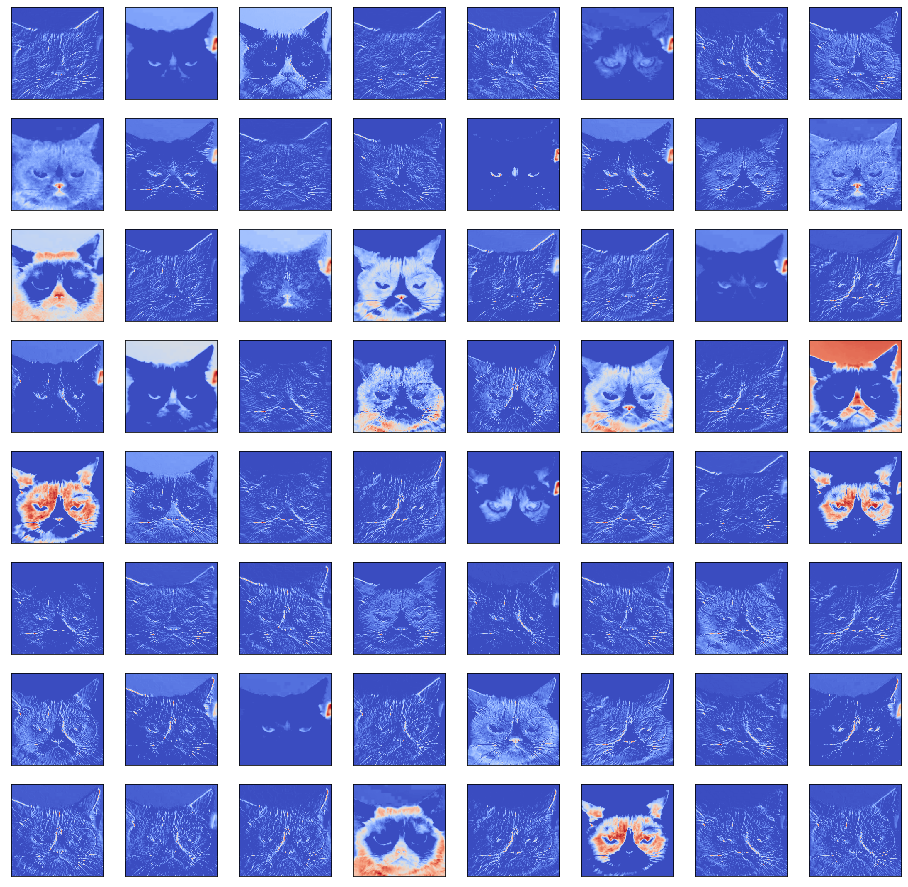

In [7]:
plt.figure(figsize=(16, 16))
for i in range(feature_maps.shape[-1]):
    ax = plt.subplot(8, 8, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_maps[0, :, :, i], cmap="coolwarm")

Shape of filter weights: (3, 3, 3, 64)


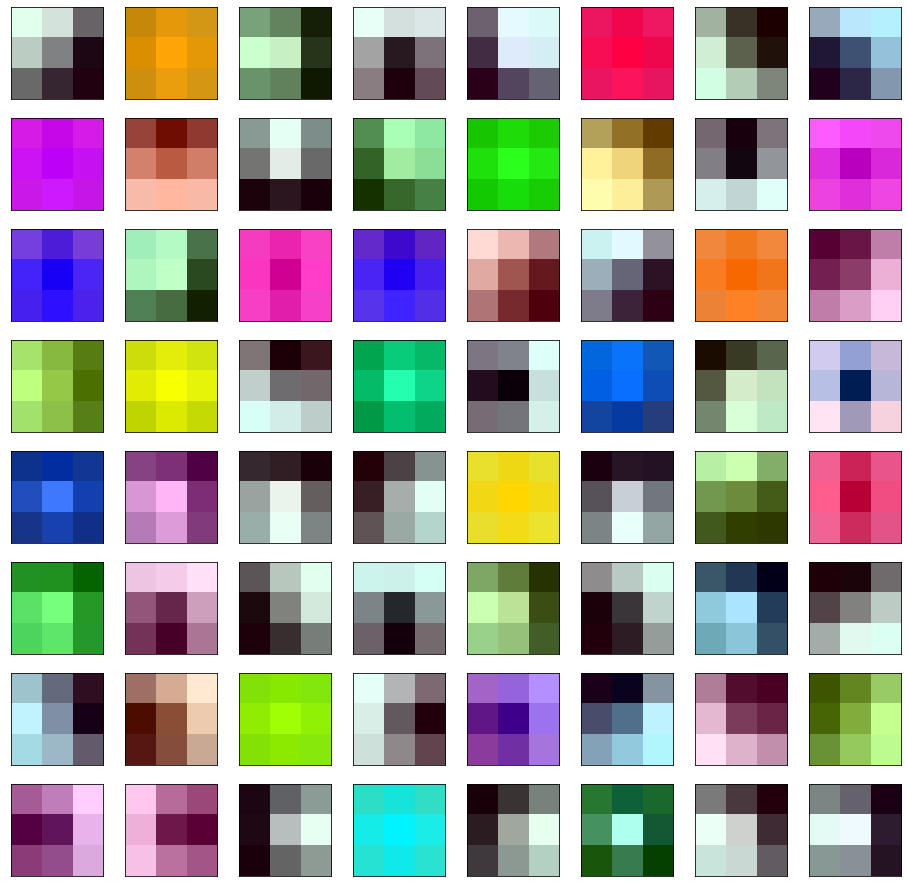

In [8]:
filters, _ = model.layers[1].get_weights()
print("Shape of filter weights: {}".format(filters.shape))

plt.figure(figsize=(16, 16))
for i in range(filters.shape[-1]):
    f = filters[:, :, :, i]
    f = (f - f.min()) / (f.max() - f.min())
    ax = plt.subplot(8, 8, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f)

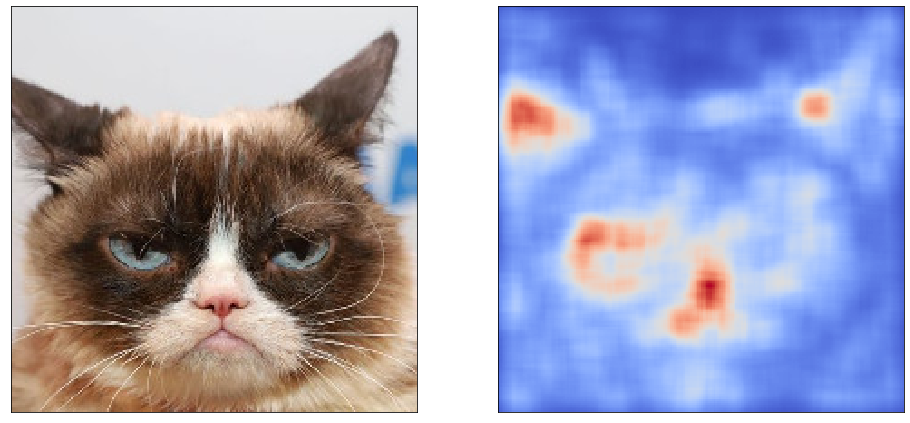

In [9]:
max_index = pred[0].argmax()
grads_op = keras.backend.gradients(model.layers[-1].output[:, max_index], model.layers[0].input)
grads_func = keras.backend.function([model.layers[0].input], grads_op)
grads = grads_func([imgarr_preproc])

grads = np.mean(np.abs(grads[0][0, :, :, :]), axis=-1)
grads = convolve2d(grads, np.ones((16, 16)), mode="same")
grads = (grads - grads.min()) / (grads.max() - grads.min())

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(imgarr.astype(np.uint8))
plt.subplot(1, 2, 2)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(grads, cmap="coolwarm");